In [2]:
import sys
import pandas as pd
import math
import os
import numpy as np
import msprime
import tskit
import libsequence
import allel
import argparse
import demes
import demesdraw
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

<H2>Figure 1</H2>

Text(600000, 300, '$r_{SAS}$=0.285')

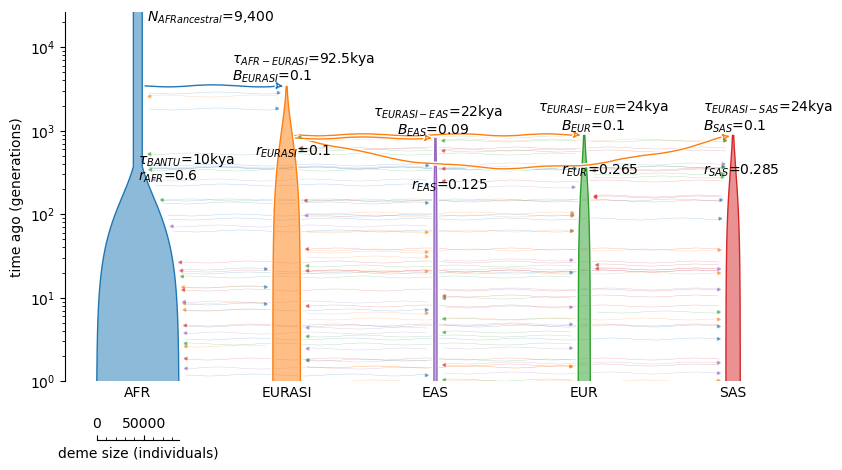

In [3]:
#####FIGURE 1B: PLOT DEMOGRAPHIC MODEL USING MSPRIME AND DEMES

#Set parameters
seq_len=43674
rec_rate=0.026768951339469705
mut_rate=5.6204730948602656e-09
T_AFR_EURASI=92.5
T_EURASI_EUR=24
T_EURASI_EAS=22
T_EURASI_SAS=24
T_BANTU=10	
r_AFR=0.6
r_EURASI=0.1
r_EUR=0.265
r_EAS=0.125
r_SAS=0.285
N_AFR_ANC=9400	
B_EURASI=0.1
B_EUR=0.1
B_EAS=0.09
B_SAS=0.1
m_AFR_EURASI=3	
m_AFR_EUR=1.5	
m_AFR_EAS=4.5
m_AFR_SAS=2.5	
m_EURASI_EUR=3
m_EURASI_EAS=3	
m_EURASI_SAS=3	
m_EUR_EAS=4
m_EUR_SAS=7.5	
m_EAS_SAS=7.5	
unmasked_length=15214

#Adjust rec rate to per site
rec_rate = rec_rate * 1e-8
# Times are provided in years, so we convert into generations.
generation_time = 26.9
T_AFR_EURASI = np.round((T_AFR_EURASI * 1e3) / generation_time,0)
T_EURASI_EUR = np.round((T_EURASI_EUR * 1e3) / generation_time,0)
T_EURASI_EAS = np.round((T_EURASI_EAS * 1e3) / generation_time,0)
T_EURASI_SAS = np.round((T_EURASI_SAS * 1e3) / generation_time,0)
T_BANTU = np.round((T_BANTU * 1e3) / generation_time,0)

#Growth rates converted from %s
r_AFR = r_AFR / 100
r_EURASI = r_EURASI / 100
r_EUR = r_EUR / 100
r_EAS = r_EAS / 100
r_SAS = r_SAS / 100

#Calculate size of EURASI population at time when daughter populations split
N_EURASI_EUR = (B_EURASI * N_AFR_ANC) / math.exp(-r_EURASI * (T_AFR_EURASI-T_EURASI_EUR))
N_EURASI_EAS = (B_EURASI * N_AFR_ANC) / math.exp(-r_EURASI * (T_AFR_EURASI-T_EURASI_EAS))
N_EURASI_SAS = (B_EURASI * N_AFR_ANC) / math.exp(-r_EURASI * (T_AFR_EURASI-T_EURASI_SAS))

#If population at time of split is <1 set to 1.
if(N_EURASI_EUR < 1):
    N_EURASI_EUR = 1
if(N_EURASI_EAS < 1):
    N_EURASI_EAS = 1
if(N_EURASI_SAS < 1):
    N_EURASI_SAS = 1

#Initial population size (ie current day)
N_AFR = N_AFR_ANC / math.exp(-r_AFR * T_BANTU)
N_EURASI = (B_EURASI * N_AFR_ANC) / math.exp(-r_EURASI * T_AFR_EURASI)

#If bottlenecks results in sizes less than 1, set to 1
if ((B_EUR * N_EURASI_EUR) < 1):
    N_EUR = 1 / math.exp(-r_EUR * T_EURASI_EUR)
else:
    N_EUR = (B_EUR * N_EURASI_EUR) / math.exp(-r_EUR * T_EURASI_EUR) 

if ((B_EAS * N_EURASI_EAS) < 1):
    N_EAS = 1 / math.exp(-r_EAS * T_EURASI_EAS)
else:
    N_EAS = (B_EAS * N_EURASI_EAS) / math.exp(-r_EAS * T_EURASI_EAS)

if ((B_SAS * N_EURASI_SAS) < 1):
    N_SAS = 1 / math.exp(-r_SAS * T_EURASI_SAS)
else:
    N_SAS = (B_SAS * N_EURASI_SAS) / math.exp(-r_SAS * T_EURASI_SAS)

demography = msprime.Demography()
demography.add_population(
    name="AFR",
    description="African population. Specifically LWK, from Kenya in 1kG",
    initial_size=N_AFR,
    growth_rate=r_AFR,
    default_sampling_time=0, 
    initially_active=True,
)
demography.add_population(
    name="EURASI",
    description=(
        "Eurasian population. This has no empirical data to compare to in 1kG"
    ),
    initial_size=N_EURASI,
    growth_rate=r_EURASI,
    default_sampling_time=0, 
    initially_active=True,
)
demography.add_population(
    name="EUR",
    description="European population. Comprised of CEU, TSI, GBR, FIN and IBS populations in 1kG",
    initial_size=N_EUR,
    growth_rate=r_EUR,
)

demography.add_population(
    name="EAS",
    description="East asian population. Comprised of CHB, JPT, CHS, CDX, KHV, and CHD populations in 1kG",
    initial_size=N_EAS,
    growth_rate=r_EAS,
)

demography.add_population(
    name="SAS",
    description="South Asian population. Comprised of GIH, PJL, BEB, STU, and ITU populations in 1kG",
    initial_size=N_SAS,
    growth_rate=r_SAS,
)

# Set the migration rates between extant populations
demography.set_symmetric_migration_rate(["AFR", "EURASI"], m_AFR_EURASI / (4*N_AFR_ANC))
demography.set_symmetric_migration_rate(["AFR", "EUR"], m_AFR_EUR / (4*N_AFR_ANC))
demography.set_symmetric_migration_rate(["AFR", "EAS"], m_AFR_EAS / (4*N_AFR_ANC))
demography.set_symmetric_migration_rate(["AFR", "SAS"], m_AFR_SAS / (4*N_AFR_ANC))
demography.set_symmetric_migration_rate(["EURASI", "EUR"], m_EURASI_EUR / (4*N_AFR_ANC))
demography.set_symmetric_migration_rate(["EURASI", "EAS"], m_EURASI_EAS / (4*N_AFR_ANC))
demography.set_symmetric_migration_rate(["EURASI", "SAS"], m_EURASI_SAS / (4*N_AFR_ANC))
demography.set_symmetric_migration_rate(["EUR", "EAS"], m_EUR_EAS / (4*N_AFR_ANC))
demography.set_symmetric_migration_rate(["EUR", "SAS"], m_EUR_SAS / (4*N_AFR_ANC))
demography.set_symmetric_migration_rate(["EAS", "SAS"], m_EAS_SAS / (4*N_AFR_ANC))

#Add events
demography.add_population_parameters_change(time=T_BANTU, population="AFR", growth_rate=0, initial_size=N_AFR_ANC)
demography.add_population_split(time=T_EURASI_EUR, derived=["EUR"], ancestral="EURASI")
demography.add_population_split(time=T_EURASI_EAS, derived=["EAS"], ancestral="EURASI")
demography.add_population_split(time=T_EURASI_SAS, derived=["SAS"], ancestral="EURASI")
demography.add_population_split(time=T_AFR_EURASI, derived=["EURASI"], ancestral="AFR")
demography.sort_events()

#Use demesdraw to plot msprime demographic model
graph = demography.to_demes()
positions = {'AFR':0, 'EURASI':1, 'EUR':2, 'EAS':3, 'SAS':4}
ax = demesdraw.tubes(graph, num_lines_per_migration=5, log_time=True, seed=1234, scale_bar=True)
ax.text(s=r"$N_{AFRancestral}$" + "=9,400", x=10000, y=20000)

ax.text(s=r"$\tau_{BANTU}$" +  "=10kya", x=0, y=400)
ax.text(s=r"$\tau_{AFR-EURASI}$" +  "=92.5kya", x=100000, y=6500)
ax.text(s=r"$\tau_{EURASI-EAS}$" +  "=22kya", x=250000, y=1500)
ax.text(s=r"$\tau_{EURASI-EUR}$" +  "=24kya", x=425000, y=1700)
ax.text(s=r"$\tau_{EURASI-SAS}$" +  "=24kya", x=600000, y=1700)

ax.text(s=r"$B_{EURASI}$" +  "=0.1", x=100000, y=4000)
ax.text(s=r"$B_{EAS}$" +  "=0.09", x=275000, y=900)
ax.text(s=r"$B_{EUR}$" +  "=0.1", x=450000, y=1000)
ax.text(s=r"$B_{SAS}$" +  "=0.1", x=600000, y=1000)

ax.text(s=r"$r_{AFR}$" + "=0.6", x=1, y=250)
ax.text(s=r"$r_{EURASI}$" +  "=0.1", x=125000, y=500)
ax.text(s=r"$r_{EAS}$" +  "=0.125", x=290000, y=200)
ax.text(s=r"$r_{EUR}$" +  "=0.265", x=450000, y=300)
ax.text(s=r"$r_{SAS}$" +  "=0.285", x=600000, y=300)

plt.savefig('/home/vsoni11/fig1.jpg', format='jpg', dpi=720)

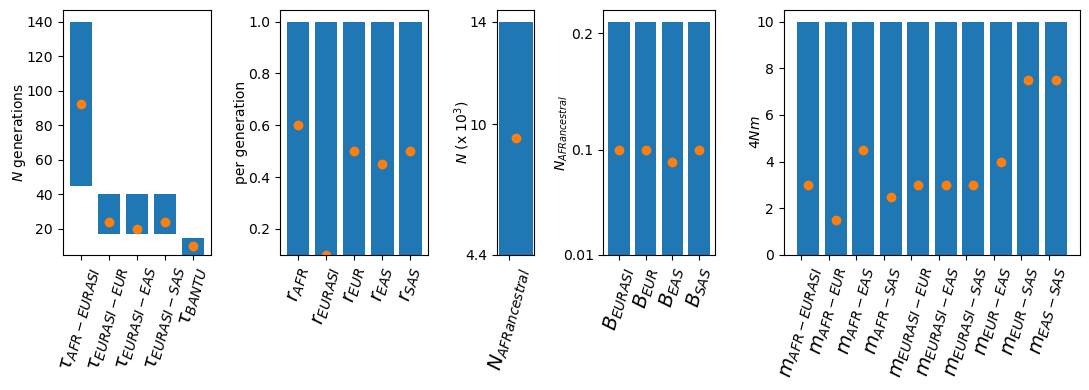

In [3]:
####FIGURE 1A: PLOT PARAMETER RANGES AND BEST FITTING PARAMETERS
f, (a0, a1, a2, a3, a4) = plt.subplots(1, 5, gridspec_kw={'width_ratios': [4, 4, 1, 3, 8]})
f.set_size_inches(11, 4) 
x = np.arange(5)
y_bot =[45, 17, 17, 17, 5]
y_dif = [140-45, 40-17, 40-17, 40-17, 15-5]
a0.bar(x, y_dif, bottom=y_bot)
a0.scatter(x, [92.5, 24, 20, 24, 10])
a0.set_xticks(x,[r"$\tau_{AFR-EURASI}$", r"$\tau_{EURASI-EUR}$", r"$\tau_{EURASI-EAS}$", r"$\tau_{EURASI-SAS}$", r"$\tau_{BANTU}$"], rotation=75)
a0.set_ylabel(r"$N$" + " generations", labelpad=-1)
a0.tick_params(axis='x', which='major', labelsize=14)

x = np.arange(5)
y_bot =[0.1, 0.1, 0.1, 0.1, 0.1]
y_dif = [0.9, 0.9, 0.9, 0.9, 0.9]
a1.bar(x, y_dif, bottom=y_bot)
a1.scatter(x, [0.6, 0.1, 0.5, 0.45, 0.5])
a1.set_xticks(x,[r"$r_{AFR}$", r"$r_{EURASI}$", r"$r_{EUR}$", r"$r_{EAS}$", r"$r_{SAS}$"], rotation=75)
a1.set_ylabel(r"per generation", labelpad=0)
a1.tick_params(axis='x', which='major', labelsize=14)

y_bot = [4400]
y_dif = [14400 - 4400]
a2.bar([0], y_dif, bottom=y_bot, width=5)
a2.scatter([0], [9400])
a2.set_xticks([-1], [r"$N_{AFRancestral}$"], rotation=75)
a2.set_yticks([4400, 10000, 14400], [r"4.4", r"10", r"14"])
a2.set_ylabel(r"$N$" + " (x " + r"$10^{3}$" + ")", labelpad=-5)
a2.tick_params(axis='x', which='major', labelsize=14)

x = np.arange(4)
y_bot =[0.01, 0.01, 0.01, 0.01]
y_dif = [0.2, 0.2, 0.2, 0.2]
a3.bar(x, y_dif, bottom=y_bot)
a3.scatter(x, [0.1, 0.1, 0.09, 0.1])
a3.set_xticks(x,[r"$B_{EURASI}$", r"$B_{EUR}$", r"$B_{EAS}$", r"$B_{SAS}$"], rotation=75)
a3.set_yticks([0.01, 0.1, 0.2], [r"0.01", r"0.1", r"0.2"])
a3.set_ylabel(r"$N_{AFRancestral}$", labelpad=-5)
a3.tick_params(axis='x', which='major', labelsize=14)

x = np.arange(10)
y_bot = [0 for x in range(0, 10)]
y_dif = [10 for x in range(0, 10)]
a4.bar(x, y_dif, bottom=y_bot)
a4.scatter(x, [3, 1.5, 4.5, 2.5, 3, 3, 3, 4, 7.5, 7.5])
a4.set_xticks([y-0.25 for y in x],[r"$m_{AFR-EURASI}$", r"$m_{AFR-EUR}$", r"$m_{AFR-EAS}$", r"$m_{AFR-SAS}$",
                 r"$m_{EURASI-EUR}$", r"$m_{EURASI-EAS}$", r"$m_{EURASI-SAS}$",
                r"$m_{EUR-EAS}$", r"$m_{EUR-SAS}$", r"$m_{EAS-SAS}$"], rotation=75)
a4.set_ylabel(r"$4Nm$", labelpad=-5)
a4.tick_params(axis='x', which='major', labelsize=14)

plt.subplots_adjust(wspace=0.55, hspace=0.5)
plt.tight_layout()
plt.savefig('/home/vsoni11/fig1A.jpg', format='jpg', dpi=720)

<H2>Figure 2</H2>

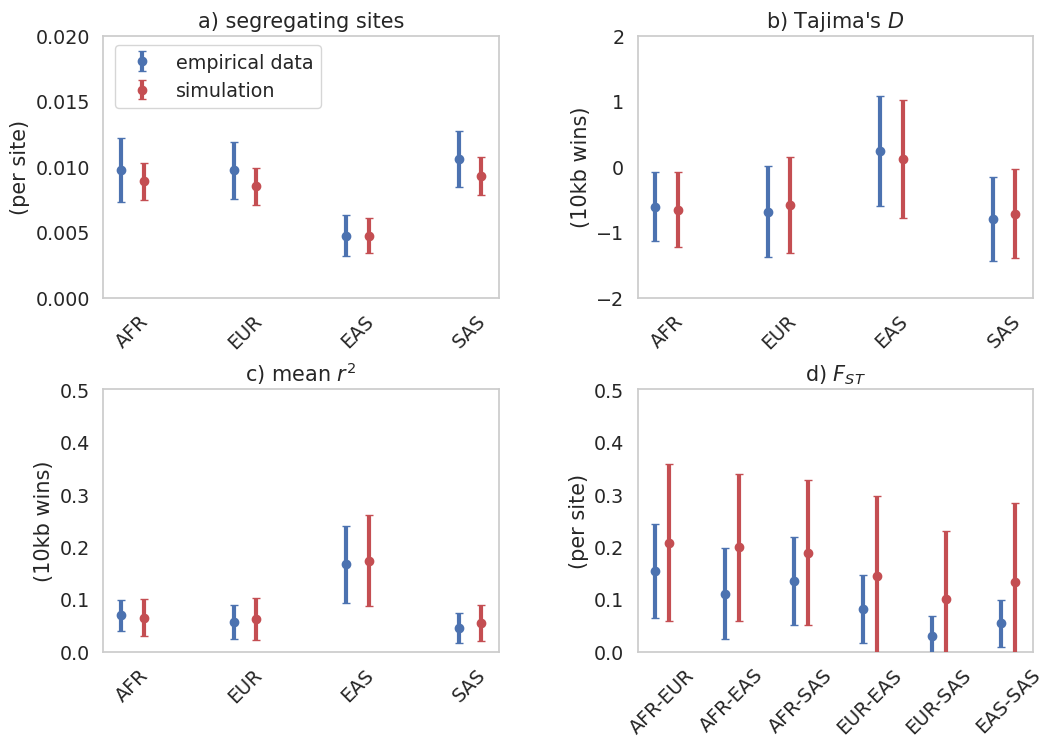

In [5]:
#Loop through per site stats, appending means and standard deviations to appropriate dataframes
df1_mean = pd.DataFrame()
df1_std = pd.DataFrame()
for i in range(1, 146):
    try:
        dfx = pd.read_csv(r"/ospool/ap21/data/vsoni11/hdd_res/demog_stats/region" + str(i) + "_perSite.txt", sep='\t', header=0)
        df = pd.DataFrame(dfx.mean()).T
        df = df.drop(columns=['replicate'])
        df1_mean = pd.concat([df1_mean, df])
        df = pd.DataFrame(dfx.std()).T
        df['region'] = i
        df = df.drop(columns=['replicate'])
        df1_std = pd.concat([df1_std, df])
    except Exception:
        pass

colNames = ['tajimasd_AFR', 'tajimasd_EUR', 'tajimasd_EAS', 'tajimasd_SAS',
                   'meanrsq_AFR', 'meanrsq_EUR', 'meanrsq_EAS', 'meanrsq_SAS']

#Repeat for windowed stats (getting mean of windows for each replicate)
df2_mean = pd.DataFrame()
df2_std = pd.DataFrame()

for i in range(1, 146):
    try:
        dfx = pd.read_csv(r"/ospool/ap21/data/vsoni11/hdd_res/demog_stats/region" + str(i) + "_windows.txt", sep='\t', header=0)
        
        df =  pd.merge(dfx.groupby(['population','replicate'])['tajimasd'].mean().reset_index(),        
                dfx.groupby(['population','replicate'])['meanrsq'].mean().reset_index(),
                on=['population', 'replicate'], how='inner')
    
        df2 =   pd.merge(df.groupby('population')['tajimasd'].mean().reset_index(),
                df.groupby('population')['meanrsq'].mean().reset_index(),
                     on='population', how='inner')

        order = ['AFR', 'EUR', 'EAS', 'SAS']
        df2['population'] = pd.Categorical(df2.population, ordered=True, categories=order)
        df2 = df2.sort_values('population')
    
        lst = [list(df2.tajimasd), list(df2.meanrsq)]
        df2 = pd.DataFrame([x for xs in lst for x in xs]).T
        df2.columns = colNames
        df2['region'] = i
        df2_mean = pd.concat([df2_mean, df2])
    
        df2 =   pd.merge(df.groupby('population')['tajimasd'].std().reset_index(),
                df.groupby('population')['meanrsq'].std().reset_index(),
                     on='population', how='inner')

        order = ['AFR', 'EUR', 'EAS', 'SAS']
        df2['population'] = pd.Categorical(df2.population, ordered=True, categories=order)
        df2 = df2.sort_values('population')
    
        lst = [list(df2.tajimasd), list(df2.meanrsq)]
        df2 = pd.DataFrame([x for xs in lst for x in xs]).T
        df2.columns = colNames
        df2['region'] = i
        df2_std = pd.concat([df2_std, df2])
    except Exception:
        pass
#Merge per site and windowed stats
df_mean = pd.merge(df1_mean, df2_mean, on='region', how='inner')
df_std = pd.merge(df1_std, df2_std, on='region', how='inner')
#Load in empirical summary stats
edf = pd.read_csv(r"/home/vsoni11/human_demog_DFE/empirical_summary_stats/empirical_summary_stats_final.txt", sep='\t', header=0)

#Plot stats
titles = ['a) segregating sites', "b) Tajima's " + r"$D$", 'c) mean $ r^2$']
pops = ['AFR','EUR','EAS','SAS']
ylabs = ['(per site)', '(10kb wins)', '(10kb wins)', '(per site)']
ylims = [[0, 0.02], [-2,2], [0,0.5], [0,0.5]]
sns.set(rc={'figure.figsize':(12,8),'axes.facecolor':'white','axes.edgecolor': '.8'},font_scale=1.25)
x = np.arange(4) 
for i, stat in enumerate(['S', 'tajimasd', 'meanrsq']):
    plt.subplot(2,2,i+1)
    for j,pop in enumerate(pops):
        if((stat=='tajimasd') & (pop=='AFR')):
            plt.errorbar([j-0.1], edf[stat + '_' + pop].mean(), edf[stat + '_' + pop].std(),
                            fmt='o', lw=3, capsize=3, zorder=15, c='b', label='empirical data')
            plt.errorbar([j+0.1], df_mean[stat + '_' + pop].mean(), df_std[stat + '_' + pop].mean(),
                            fmt='o', lw=3, capsize=3, zorder=15, c='r', label='simulation') 
        else:
            plt.errorbar([j-0.1], edf[stat + '_' + pop].mean(), edf[stat + '_' + pop].std(),
                            fmt='o', lw=3, capsize=3, zorder=15, c='b')
            plt.errorbar([j+0.1], df_mean[stat + '_' + pop].mean(), df_std[stat + '_' + pop].mean(),
                            fmt='o', lw=3, capsize=3, zorder=15, c='r')  
        plt.xticks(x, pops, rotation=45)
        plt.title(titles[i])
    plt.ylabel(ylabs[i])
    plt.ylim(ylims[i])
    if(stat=='tajimasd'):
        plt.yticks([-2,-1,0,1,2])
        plt.legend(bbox_to_anchor=(-0.775, 1))
        
plt.subplot(2,2,4)
x = np.arange(6) 
pops = ['AFR_EUR','AFR_EAS', 'AFR_SAS','EUR_EAS','EUR_SAS', 'EAS_SAS']
for j, pop in enumerate(pops):
            plt.errorbar([j-0.1], edf['Fst_' + pop].mean(), edf['Fst_' + pop].std(),
                            fmt='o', lw=3, capsize=3, zorder=15, c='b')
            plt.errorbar([j+0.1], df_mean['Fst_' + pop].mean(), df_std['Fst_' + pop].mean(),
                            fmt='o', lw=3, capsize=3, zorder=15, c='r')     
plt.xticks(x, ['AFR-EUR','AFR-EAS', 'AFR-SAS','EUR-EAS','EUR-SAS', 'EAS-SAS'], rotation=45)
plt.title(r'd) $F_{ST}$')
plt.ylabel(ylabs[3])
plt.ylim(ylims[3])

plt.subplots_adjust(wspace=0.35, hspace=0.35)
plt.savefig('/home/vsoni11/human_demog_DFE/fig2.tiff', format='tiff', dpi=300, bbox_inches='tight')
plt.savefig('/home/vsoni11/human_demog_DFE/fig2.png', format='png', dpi=300, bbox_inches='tight')

<H2>Figure 3</H2>

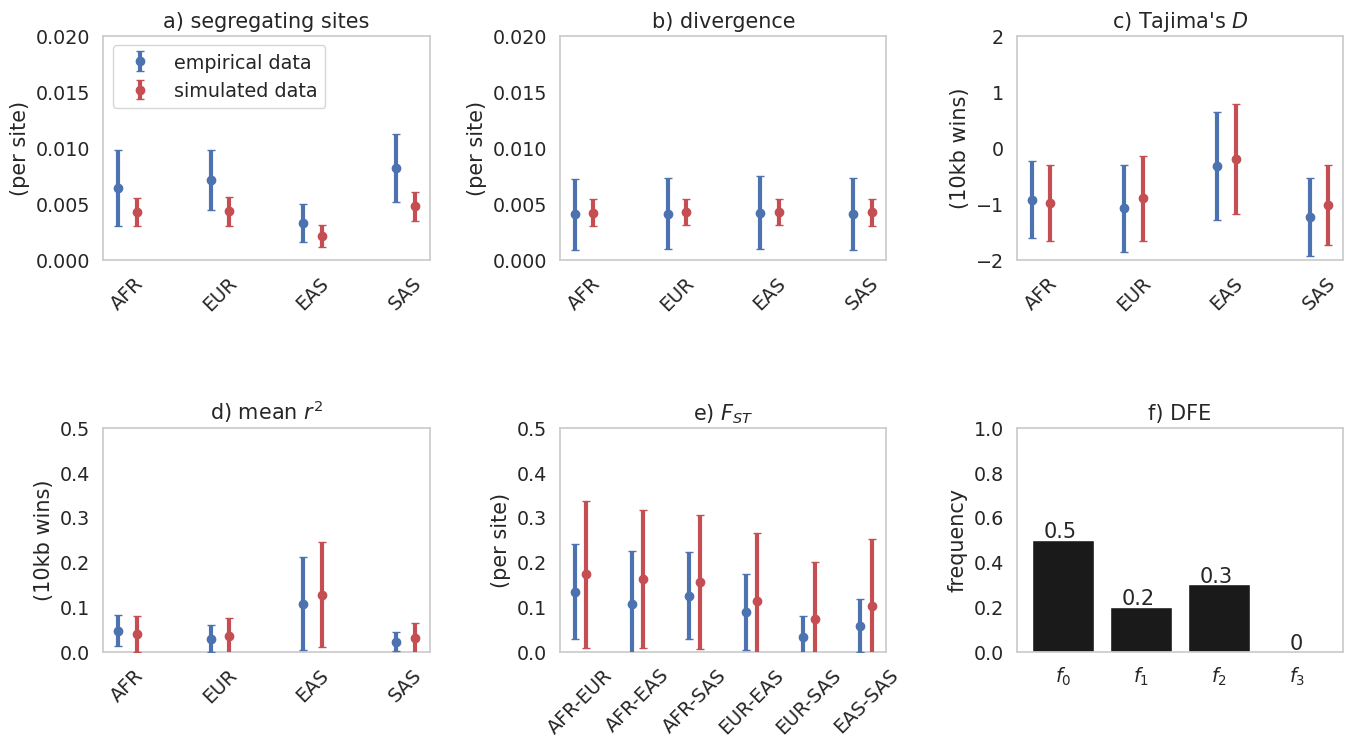

In [17]:
#As before loop through regions, getting means and standard deviations across replicates
dfm = pd.DataFrame()
dfs = pd.DataFrame()
for region in range(1, 398):
    try:
        df = pd.read_csv(r"/ospool/ap21/data/vsoni11/hdd_res/demog_DFE_div_stats/region" + str(region) + ".stats", sep='\t', header=0)

        df_m = pd.DataFrame(df.mean()).T
        df_m = df_m.drop(columns=['rep'])
        df_m['region'] = region
        dfm = pd.concat([dfm, df_m])
        
        df_s = pd.DataFrame(df.std()).T
        df_s = df_s.drop(columns=['rep'])
        df_s['region'] = region
        dfs = pd.concat([dfs, df_s])
    except Exception:
        pass

#Read in empirical summary stats
edf = pd.read_csv(r"/home/vsoni11/human_demog_DFE/DFE_inference/empirical_summary_stats/empirical_summary_stats_final.txt", sep='\t', header=0)
edf = edf[edf.region_type=='exons']
edf = edf.drop(columns=['region_type'])
#Read in empirical divergence
ddf = pd.read_csv(r"/home/vsoni11/human_demog_DFE/DFE_inference/empirical_summary_stats/empirical_divergence.txt", sep='\t', header=0)
ddf['population'] = np.where(ddf.population=='LWK', 'AFR', ddf.population)
ddf = ddf.drop(columns=['intergenic_divergence', 'divergence_ratio'])
ddf = ddf.rename(columns={'exonic_divergence':'divergence'})
#invert df columns    
rdf = ddf[ddf.population=='AFR']
rdf = rdf.drop(columns='population')
rdf.columns = ['region', 'divergence_AFR']

for pop in ['EUR', 'EAS', 'SAS']:
    tdf = ddf[ddf.population==pop]
    tdf = tdf.drop(columns='population')
    tdf.columns = ['region', 'divergence_'+pop]
    rdf = pd.merge(rdf, tdf, on=['region'], how='inner')

edf = pd.merge(edf, rdf, on='region', how='inner')

#Plot
titles = ['a) segregating sites', 'b) divergence', "c) Tajima's " + r"$D$", 'd) mean $ r^2$']
pops = ['AFR','EUR','EAS','SAS']
ylabs = ['(per site)', '(per site)', '(10kb wins)', '(10kb wins)', '(per site)']
ylims = [[0, 0.02], [0, 0.02], [-2,2], [0,0.5], [0,0.5]]
sns.set(rc={'figure.figsize':(16,8),'axes.facecolor':'white','axes.edgecolor': '.8'},font_scale=1.25)
x = np.arange(4) 
for i, stat in enumerate(['S', 'divergence', 'tajimasd', 'meanrsq']):
    plt.subplot(2,3,i+1)
    for j,pop in enumerate(pops):
        plt.errorbar([j-0.1], edf[stat + '_' + pop].mean(), edf[stat + '_' + pop].std(),
                    fmt='o', lw=3, capsize=3, zorder=15, c='b')
        plt.errorbar([j+0.1], dfm[stat + '_' + pop].mean(), dfs[stat + '_' + pop].mean(),
                        fmt='o', lw=3, capsize=3, zorder=15, c='r')  
         
        plt.xticks(x, pops, rotation=45)
        plt.title(titles[i])
    plt.ylabel(ylabs[i])
    plt.ylim(ylims[i])

plt.subplot(2,3,5)
x = np.arange(6) 
pops = ['AFR_EUR','AFR_EAS', 'AFR_SAS','EUR_EAS','EUR_SAS', 'EAS_SAS']
for j, pop in enumerate(pops):
    if(pop=='AFR_EUR'):
        plt.errorbar([j-0.1], edf['Fst_' + pop].mean(), edf['Fst_' + pop].std(),
                        fmt='o', lw=3, capsize=3, zorder=15, c='b', label='empirical data')
        plt.errorbar([j+0.1], dfm['Fst_' + pop].mean(), dfs['Fst_' + pop].mean(),
                        fmt='o', lw=3, capsize=3, zorder=15, c='r', label='simulated data') 
    else:
        plt.errorbar([j-0.1], edf['Fst_' + pop].mean(), edf['Fst_' + pop].std(),
                        fmt='o', lw=3, capsize=3, zorder=15, c='b')
        plt.errorbar([j+0.1], dfm['Fst_' + pop].mean(), dfs['Fst_' + pop].mean(),
                        fmt='o', lw=3, capsize=3, zorder=15, c='r')         
plt.legend(bbox_to_anchor=(-0.69, 2.75))
plt.xticks(x, ['AFR-EUR','AFR-EAS', 'AFR-SAS','EUR-EAS','EUR-SAS', 'EAS-SAS'], rotation=45)
plt.title(r'e) $F_{ST}$')
plt.ylabel(ylabs[4])
plt.ylim(ylims[4])

#Final plot in figure is of discrete DFE
plt.subplot(2,3,6)
[0.1,0.7,0.1,0.1]
plt.bar(x=[a for a in range(0,4)], height=[0.5,0.2,0.3,0], color='k')
plt.ylabel('frequency')
plt.xticks([a for a in range(0,4)], [r'$f_0$', r'$f_1$', r'$f_2$', r'$f_3$'])
plt.ylim([0,1])
plt.title('f) DFE')
plt.text(-0.25, 0.51, s='0.5')
plt.text(0.75, 0.21, s='0.2')
plt.text(1.75, 0.31, s='0.3')
plt.text(2.9, 0.01, s='0')

plt.subplots_adjust(wspace=0.4, hspace=0.75)
plt.savefig('/home/vsoni11/human_demog_DFE/fig3.tiff', format='tiff', dpi=300, bbox_inches='tight')
plt.savefig('/home/vsoni11/human_demog_DFE/fig3.png', format='png', dpi=300, bbox_inches='tight')

<H2>Figure 4</H2>

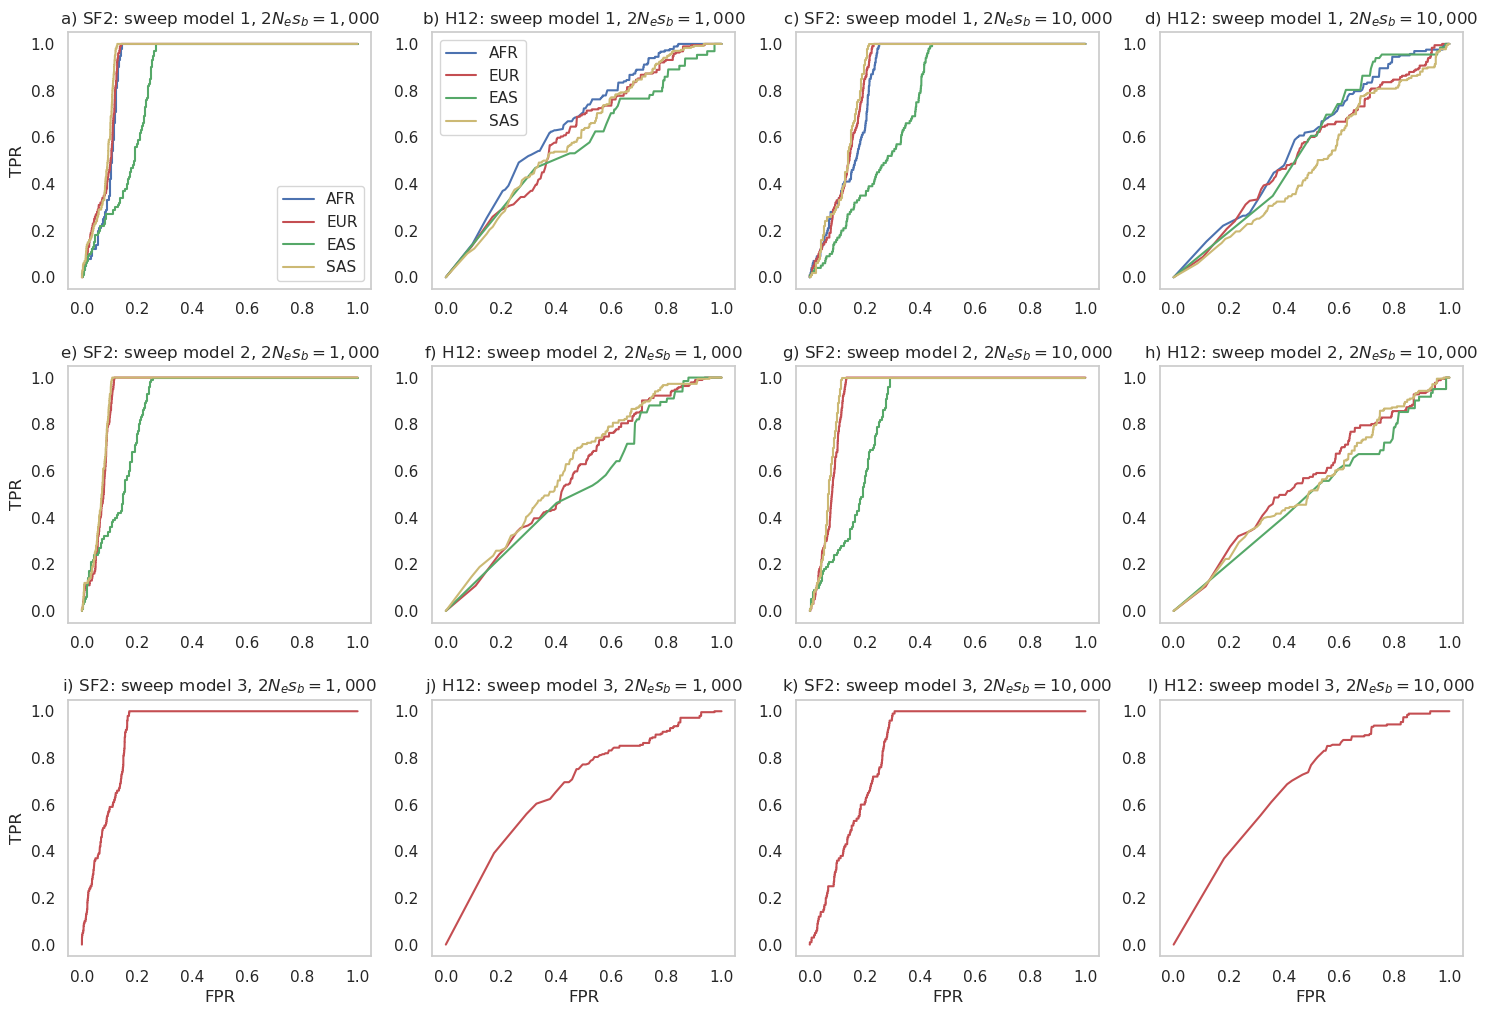

In [7]:
#Set beneficial mutation position and region length
sweep_pos = 97011
regionLen = 198345
pops = {'AFR':'p1', 'EUR':'p3', 'EAS':'p5', 'SAS':'p4'}
rdf = pd.DataFrame()
#Loop through 2Nes values, and models, limiting populations to the model in question (models have different sampled populations)
for Nes in [1000, 10000]:
    for model in range(1,4):
        if(model==1):
            pops = ['AFR','EUR','EAS','SAS']
        if(model==2):
            pops = ['EUR','EAS','SAS']
        if(model==3):
            pops = ['EUR']
        #Loop through populations and replicates, loading in SweepFinder results
        for pop in pops:
            for rep in range(1, 101):
                #Read in SF results
                sf = pd.read_csv(r"/ospool/ap21/data/vsoni11/hdd_res/sweep_detection/singleSweep/SF_files/" + str(Nes) + "/" + str(Nes) + "_" + 
                                 pop + "_rep" + str(rep) + "_model" + str(model) + ".clr", 
                             sep='\t', header=0)   
                #Create new binary column for whether sweep exists or not
                sf['sweep'] = np.where(sf.location==sweep_pos, 1, 0)
                sf['2Nes'] = Nes
                sf['model'] = model
                sf['population'] = pop
                sf['rep'] = rep        
                rdf = pd.concat([rdf, sf])

#Set dict for colors and lists for titles
p_cols = {'AFR':'b', 'EUR':'r', 'EAS':'g', 'SAS':'y'}
l1 = ['a) SF2: sweep model 1, ', 'e) SF2: sweep model 2, ', 'i) SF2: sweep model 3, ']
l2 = ['c) SF2: sweep model 1, ', 'g) SF2: sweep model 2, ', 'k) SF2: sweep model 3, ']
p = [1,5,9]
sns.set(rc={'figure.figsize':(18,12),'axes.facecolor':'white','axes.edgecolor': '.8'},font_scale=1)
for i in range(1, 4):
    model = i
    plt.subplot(3,4,p[i-1])
    if(model==1):
        pops = ['AFR','EUR','EAS','SAS']
    if(model==2):
        pops = ['EUR','EAS','SAS']
    if(model==3):
        pops = ['EUR']    
        
    for pop in pops:
        ddf = rdf[(rdf['2Nes']==1000) & (rdf.model==model) & (rdf.population==pop)]
        ddf = ddf.dropna()
        fpr, tpr, thresholds = metrics.roc_curve(ddf.sweep, ddf['LR'])
        plt.plot(fpr,tpr, color=p_cols[pop], label=pop)
    plt.ylabel('TPR')
    if(i==1):
        plt.legend()
    elif(i==3):
        plt.xlabel('FPR')
    plt.title(l1[i-1] + r"$2N_es_b = 1,000$")
    
    plt.subplot(3,4,p[i-1]+2)
    for pop in pops:
        ddf = rdf[(rdf['2Nes']==10000) & (rdf.model==model) & (rdf.population==pop)]
        ddf = ddf.dropna()
        fpr, tpr, thresholds = metrics.roc_curve(ddf.sweep, ddf['LR'])
        plt.plot(fpr,tpr, color=p_cols[pop], label=pop)
    
    plt.title(l2[i-1] + r"$2N_es_b = 10,000$")
    if(i==3):
        plt.xlabel('FPR')

l1 = ['b) H12: sweep model 1, ', 'f) H12: sweep model 2, ', 'j) H12: sweep model 3, ']
l2 = ['d) H12: sweep model 1, ', 'h) H12: sweep model 2, ', 'l) H12: sweep model 3, ']
sweep_pos = 97011
regionLen = 198345
pops = {'AFR':'p1', 'EUR':'p3', 'EAS':'p5', 'SAS':'p4'}
winSize = '1kb'
rdf = pd.DataFrame()
for Nes in [1000, 10000]:
    for model in range(1,4):
        if(model==1):
            pops = ['AFR','EUR','EAS','SAS']
        if(model==2):
            pops = ['EUR','EAS','SAS']
        if(model==3):
            pops = ['EUR']
        for pop in pops:
            for rep in range(1, 101):
                #Read in SF results
                sf = pd.read_csv(r"/ospool/ap21/data/vsoni11/hdd_res/sweep_detection/singleSweep/h12/" + str(Nes) + "/" + str(Nes) + "_" + 
                                 pop + "_rep" + str(rep) + "_model" + str(model) + "_" +
                                 winSize + ".h12", sep='\t', header=0)       
                sf = sf.rename(columns={'snp_position':'location'})
                binary = [0 for x in range(0, len(sf))]
                for i in range(0, len(sf)):
                    if((sweep_pos >= sf.win_start[i]) & (sweep_pos <= sf.win_end[i])):
                        binary[i] = 1
                sf['sweep'] = binary
                sf['2Nes'] = Nes
                sf['model'] = model
                sf['population'] = pop
                sf['rep'] = rep        
                rdf = pd.concat([rdf, sf])

for i in range(1, 4):
    model = i
    plt.subplot(3,4,p[i-1]+1)
    if(model==1):
        pops = ['AFR','EUR','EAS','SAS']
    if(model==2):
        pops = ['EUR','EAS','SAS']
    if(model==3):
        pops = ['EUR']    
        
    for pop in pops:
        ddf = rdf[(rdf['2Nes']==1000) & (rdf.model==model) & (rdf.population==pop)]
        ddf = ddf.dropna()
        fpr, tpr, thresholds = metrics.roc_curve(ddf.sweep, ddf['H12'])
        plt.plot(fpr,tpr, color=p_cols[pop], label=pop)
    if(i==1):
        plt.legend()
    plt.title(l1[i-1] + r"$2N_es_b = 1,000$")
    if(i==3):
        plt.xlabel('FPR')
    
    plt.subplot(3,4,p[i-1]+3)
    for pop in pops:
        ddf = rdf[(rdf['2Nes']==10000) & (rdf.model==model) & (rdf.population==pop)]
        ddf = ddf.dropna()
        fpr, tpr, thresholds = metrics.roc_curve(ddf.sweep, ddf['H12'])
        plt.plot(fpr,tpr, color=p_cols[pop], label=pop)
    plt.title(l2[i-1] + r"$2N_es_b = 10,000$")
    if(i==3):
        plt.xlabel('FPR')

plt.subplots_adjust(wspace=0.2, hspace=0.3)
plt.savefig('/home/vsoni11/human_demog_DFE/fig5.tiff', format='tiff', dpi=300, bbox_inches='tight')
plt.savefig('/home/vsoni11/human_demog_DFE/fig5.png', format='png', dpi=300, bbox_inches='tight')